# Model Evaluation Notebook

This notebook evaluates the performance of the trained transformer model against baseline methods.

## Setup and Data Loading

In [1]:
import sys

sys.path.append("..")
from core.DataLoader import DataPreprocessor, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.keras_models as Models
import core
import os

# Configuration
if False:
    PLOTS_DIR = "plots/ToponiumInfusedTransformer/"
    MODEL_DIR = "models/mixed_model"
elif True:
    PLOTS_DIR = "plots/RegressionTransformer_nu_flows_neutrino_only/"
    MODEL_DIR = "../models/regression_transformer/"

else:
    PLOTS_DIR = "plots/RegressionTransformer_/"
    MODEL_DIR = "../models/regression_transformer_old/"


CONFIG_PATH = "../config/workspace_config.yaml"

# Create directories
os.makedirs(PLOTS_DIR, exist_ok=True)

# Set plotting style
plt.rcParams.update({"font.size": 18})

# Load data
load_config = get_load_config_from_yaml(CONFIG_PATH)
DataProcessor = DataPreprocessor(load_config)
PREDICTIONS_DIR = os.path.join(load_config.data_dir, "RegressionTransformer_nu_flows_neutrino_only", "odd_predictions/")

data_config = DataProcessor.load_from_npz(
    load_config.data_path["nominal"], event_numbers="odd"
)
X,y = DataProcessor.get_data()
del DataProcessor

2026-01-20 15:44:46.172487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768920286.316878  749402 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768920286.361727  749402 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768920286.696995  749402 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768920286.697025  749402 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768920286.697028  749402 computation_placer.cc:177] computation placer alr

## Load Model and Setup Evaluator

In [2]:
reload(Models)
reload(core)
Transformer = Models.FeatureConcatFullReconstructor(
    data_config, name=r"Transformer"
)
MODEL_DIR = "../models/regression_transformer/"
Transformer.load_model(f"{MODEL_DIR}/model.keras")
Transformer_nu_flows = Models.FeatureConcatFullReconstructor(
    data_config, name=r"Transformer", use_nu_flows=True
)
Transformer_nu_flows.load_model(f"{MODEL_DIR}/model.keras")


I0000 00:00:1768920456.685632  749402 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14807 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Model loaded from ../models/regression_transformer//model.keras
Training history loaded from ../models/regression_transformer//model_history.npz
Model loaded from ../models/regression_transformer//model.keras
Training history loaded from ../models/regression_transformer//model_history.npz


In [3]:
import core.reconstruction.BaselineMethods as BaselineMethods
import core.evaluation.reconstruction_evaluator as Evaluation
from core.reconstruction import (
    GroundTruthReconstructor,
    PerfectAssignmentReconstructor,
    CompositeNeutrinoComponentReconstructor,
)

reload(Evaluation)
reload(BaselineMethods)
ground_truth_assigner = GroundTruthReconstructor(data_config, use_nu_flows=True)
perfect_assigner = PerfectAssignmentReconstructor(
    data_config, neutrino_reco_name=r"Transformer $\nu$"
)
MODEL_DIR = "../models/regression_transformer/"
perfect_assigner.load_model(f"{MODEL_DIR}/model.keras")

prediction_manager = Evaluation.PredictionManager(
    [ground_truth_assigner, perfect_assigner], X, y, load_directory=PREDICTIONS_DIR
)


evaluator = Evaluation.ReconstructionEvaluator(prediction_manager)

Model loaded from ../models/regression_transformer//model.keras
Training history loaded from ../models/regression_transformer//model_history.npz
Predictions loaded for True Assignment + $\nu^2$-Flows.
Predictions loaded for True Assignment + Transformer $\nu$.


In [4]:
transformer_nu = evaluator.prediction_manager.get_neutrino_predictions(0)
nu_flows_nu = evaluator.prediction_manager.get_neutrino_predictions(1)
nu_truth = evaluator.y_test["neutrino_truth"]
valid_mask = ~np.isnan(transformer_nu).any(axis=(1,2)) & ~np.isnan(nu_flows_nu).any(axis=(1,2)) & np.isfinite(transformer_nu).all(axis=(1,2)) & np.isfinite(nu_flows_nu).all(axis=(1,2)) & ~np.isnan(nu_truth).any(axis=(1,2)) & np.isfinite(nu_truth).all(axis=(1,2))

#print("Number of invalid events:", np.sum(~valid_mask) ,"out of", len(valid_mask))
transformer_nu_valid = transformer_nu[valid_mask]
nu_flows_nu_valid = nu_flows_nu[valid_mask]
nu_truth_valid = nu_truth[valid_mask]

print("Transformer neutrino mean diff:", np.mean(np.abs(transformer_nu_valid - nu_truth_valid), axis=0)/1e3)
print("Nu-flows neutrino mean diff:", np.mean(np.abs(nu_flows_nu_valid - nu_truth_valid), axis=0)/1e3)

Transformer neutrino mean diff: [[33.2283   33.200176 85.9043  ]
 [33.024357 32.94354  85.5294  ]]
Nu-flows neutrino mean diff: [[25.684242 25.707827 74.00735 ]
 [25.669018 25.51312  73.977135]]


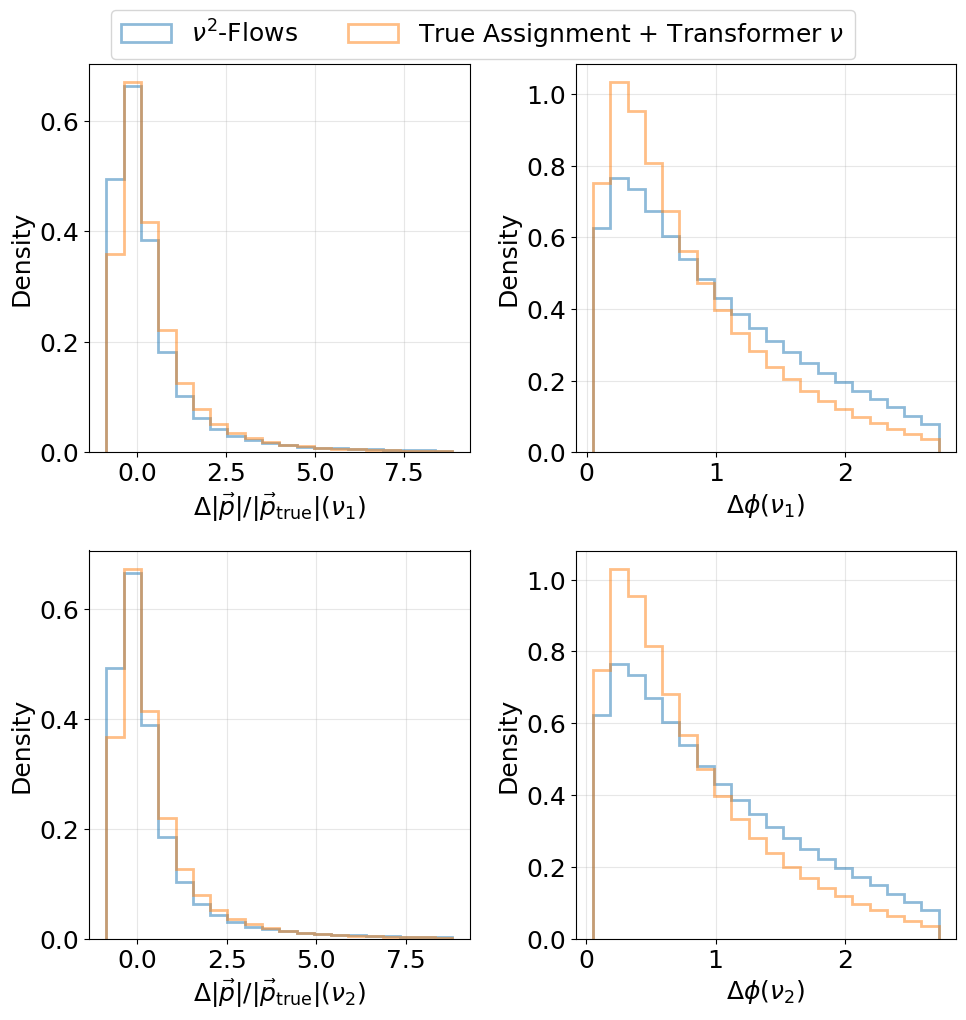

In [5]:
fig, ax = evaluator.plot_relative_neutrino_deviations(bins=20, coords="spherical")
fig.savefig(f"{PLOTS_DIR}/neutrino_reconstruction_comparison.pdf", bbox_inches="tight")

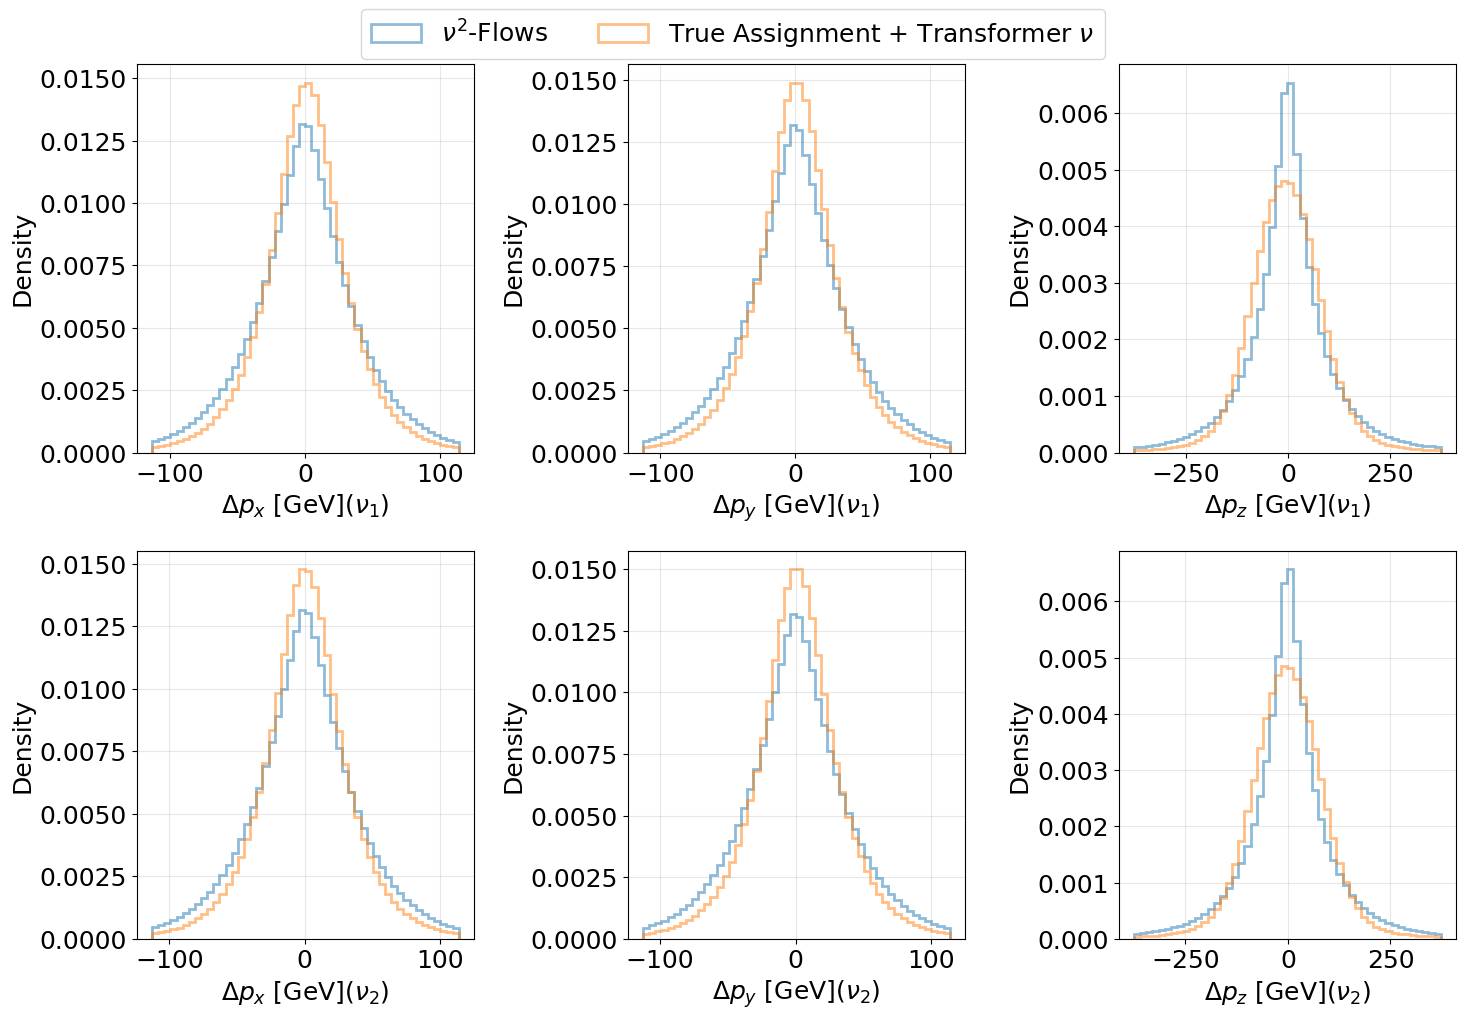

In [6]:
fig, ax = evaluator.plot_relative_neutrino_deviations(bins=50, coords="cartesian")
fig.savefig(f"{PLOTS_DIR}/neutrino_reconstruction_comparison.pdf", bbox_inches="tight")

/tmp/ipykernel_749402/887055952.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{tick/1e3:.1f}" for tick in ticks])


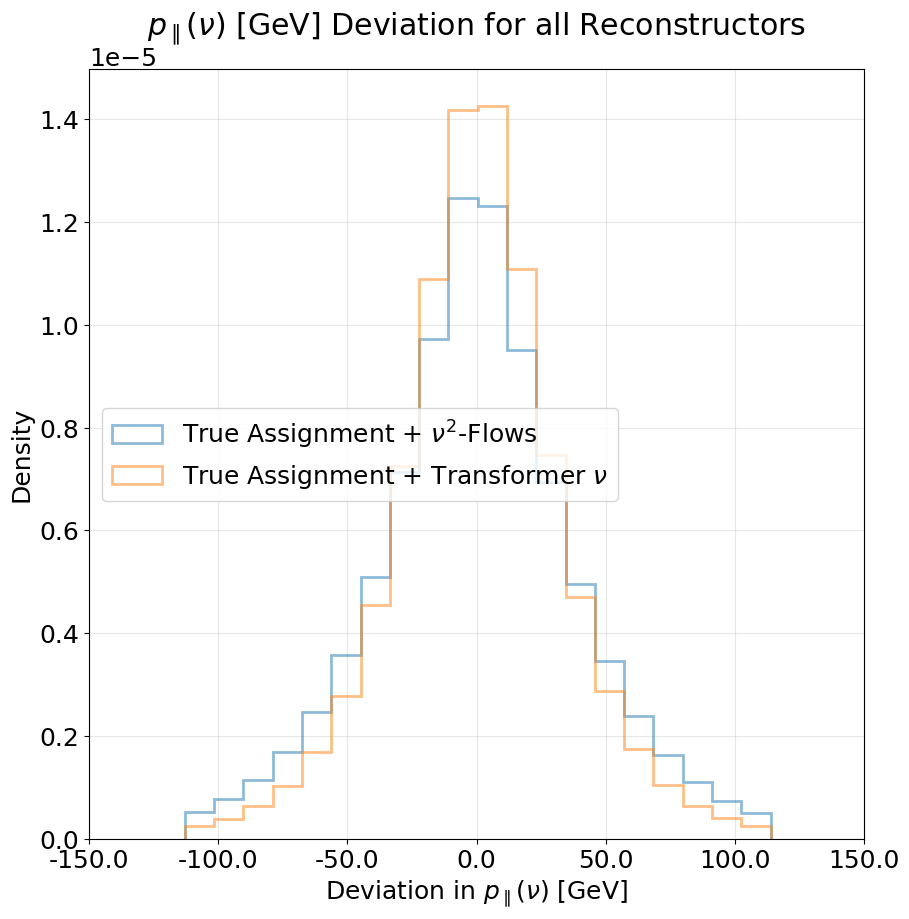

In [7]:
fig, ax = evaluator.plot_variable_deviation(
    "parallel_component_nu", bins=20
)
ticks = ax.get_xticks()
ax.set_xticklabels([f"{tick/1e3:.1f}" for tick in ticks])
ax.set_xticks(ticks)
ax.legend(loc="center left")

fig.savefig(os.path.join(PLOTS_DIR, "nu_parallel_component_deviation.pdf"))

/tmp/ipykernel_749402/459096690.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{tick/1e3:.1f}" for tick in ticks])


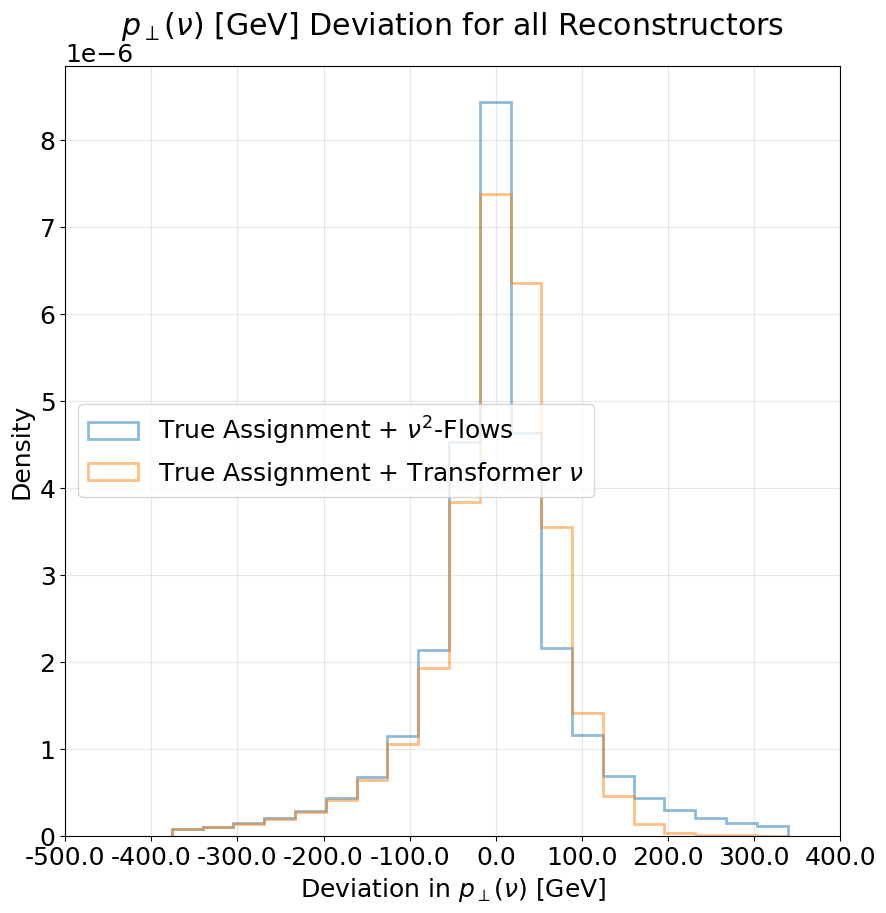

In [8]:
fig, ax = evaluator.plot_variable_deviation(
    "perpendicular_component_nu", bins=20
)
ticks = ax.get_xticks()
ax.set_xticklabels([f"{tick/1e3:.1f}" for tick in ticks])
ax.set_xticks(ticks)
ax.legend(loc="center left")
fig.savefig(os.path.join(PLOTS_DIR, "nu_perpendicular_component_deviation.pdf"))

In [ ]:
fig, ax = evaluator.plot_binned_variable(
    "nu_px", "deviation","non_training", "truth_ttbar_mass", xlims=(340e3,800e3), bins=10, fancy_feature_label=r"$m(t\bar{t})$ [GeV]"
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3,800e3)
fig.savefig(f"{PLOTS_DIR}/neutrino_px_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_binned_variable(
    "nu_py", "deviation","non_training", "truth_ttbar_mass", xlims=(340e3,800e3), bins=10, fancy_feature_label=r"$m(t\bar{t})$ [GeV]"
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3,800e3)
fig.savefig(f"{PLOTS_DIR}/neutrino_py_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")

fig, ax = evaluator.plot_binned_variable(
    "nu_pz", "deviation","non_training", "truth_ttbar_mass", xlims=(340e3,800e3), bins=10, fancy_feature_label=r"$m(t\bar{t})$ [GeV]"
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3,800e3)
fig.savefig(f"{PLOTS_DIR}/neutrino_pz_deviation_vs_ttbar_mass.pdf", bbox_inches="tight")


In [9]:
transformer_nu = evaluator.prediction_manager.get_neutrino_predictions(1)
nu_flows_nu = evaluator.prediction_manager.get_neutrino_predictions(0)
nu_truth = evaluator.y_test["neutrino_truth"]
valid_mask = ~np.isnan(transformer_nu).any(axis=(1,2)) & ~np.isnan(nu_flows_nu).any(axis=(1,2)) & np.isfinite(transformer_nu).all(axis=(1,2)) & np.isfinite(nu_flows_nu).all(axis=(1,2)) & ~np.isnan(nu_truth).any(axis=(1,2)) & np.isfinite(nu_truth).all(axis=(1,2))
transformer_nu_valid = transformer_nu[valid_mask]
nu_flows_nu_valid = nu_flows_nu[valid_mask]
nu_truth_valid = nu_truth[valid_mask]

print("Transformer neutrino mean diff:", np.mean(np.square(transformer_nu_valid - nu_truth_valid)/1e6, axis=0))
print("Nu-flows neutrino mean diff:", np.mean(np.square(nu_flows_nu_valid - nu_truth_valid)/1e6, axis=0))

Transformer neutrino mean diff: [[ 1284.4307  1291.2502 11668.525 ]
 [ 1277.6686  1272.9275 11694.078 ]]
Nu-flows neutrino mean diff: [[ 2612.296   2586.5232 22286.686 ]
 [ 2493.5242  2450.11   21875.6   ]]


In [10]:
print(np.mean(np.linalg.norm(transformer_nu_valid, axis=-1) - np.linalg.norm(nu_truth_valid, axis=-1) ))
print(np.mean(np.linalg.norm(nu_flows_nu_valid, axis=-1) - np.linalg.norm(nu_truth_valid, axis=-1) ))

-7217.432
5166.0986
